Задание #1: в ноутбуке 001 представлена реализация HOG дескриптора, не инвариантного к повороту изображений. Задание: модифицировать процедуру построения дескриптора таким образом, чтобы добиться инвариантности относительно поворота изображений, сделать демонстрацию на нескольких изображениях с явным подсчётом l1, l2.

In [76]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [77]:
print('OpenCV version:', cv2.__version__)

OpenCV version: 4.8.1


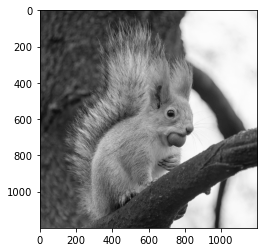

In [78]:
img_1 = cv2.imread("squirrel.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_1, cmap='gray')

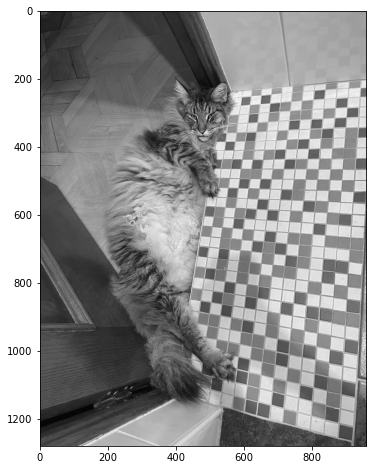

In [94]:
img_2 = cv2.imread("thor.jpg", cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_2, cmap='gray')
plt.show()

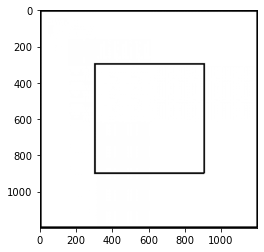

In [80]:
img_3 = cv2.imread("square.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_3, cmap='gray')

In [81]:
def hog(img, mode = "stats"):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    bin_n = 16
    bin = np.int32(bin_n * ang / (2 * np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 8

    for i in range(0, int(img.shape[0] / celly)):
        for j in range(0, int(img.shape[1] / cellx)):
            temp = bin[i * celly : i * celly + celly, j * cellx : j * cellx + cellx] # берем конкретное окно
            values, counts = np.unique(temp.ravel(), return_counts=True) # считаем кол-во значений

            dict_v_c = dict(zip(values, counts))
            dict_c_v = dict(zip(counts, values))

            norm_coef = counts.max()

            if mode == "stats":
                temp_answer = []

                for k in range(bin_n):
                    if k in dict_v_c:
                        temp_answer.append(dict_v_c[k] / norm_coef)
                    else:
                        temp_answer.append(0.0)

                bin_cells.append(temp_answer)
            else:
                bin_cells.append(dict_c_v[norm_coef])

    return np.array(bin_cells).ravel()

In [82]:
def hog_rot_invariant(img, mode="stats"):
    # Вычисляем градиенты
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    bin_n = 16  # число бинов
    bin = np.int32(bin_n * ang / (2 * np.pi))  # углы квантованные в бины

    bin_cells = []
    cellx = celly = 8

    for i in range(0, int(img.shape[0] / celly)):
        for j in range(0, int(img.shape[1] / cellx)):
            temp = bin[i * celly: i * celly + celly, j * cellx: j * cellx + cellx]
            magnitude = mag[i * celly: i * celly + celly, j * cellx: j * cellx + cellx]

            # Нормализуем накопленную гистограмму
            histogram = np.zeros(bin_n, dtype=np.float32)
            for k in range(celly):
                for l in range(cellx):
                    bin_idx = temp[k, l]
                    histogram[bin_idx] += magnitude[k, l]
            
            # Вычисляем основной угол и выполняем выравнивание
            max_bin = np.argmax(histogram)
            aligned_histogram = np.roll(histogram, -max_bin)
            norm_coef = np.sum(aligned_histogram) if mode == "l1" else np.linalg.norm(aligned_histogram)

            if norm_coef != 0:
                aligned_histogram /= norm_coef  # Нормализуем
            bin_cells.append(aligned_histogram)

    return np.array(bin_cells).ravel()

In [83]:
def rotate_image(image, angle):
    
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

In [84]:
def compare_hog_descriptors(image_path):
    # Загружаем изображение
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    angles = [0, 45, 90, 135]
    descriptors_original = []
    descriptors_invariant = []

    for angle in angles:
        rotated_img = rotate_image(gray_img, angle)
        
        descriptor_orig = hog(rotated_img)
        descriptor_invar = hog_rot_invariant(rotated_img)

        descriptors_original.append(descriptor_orig)
        descriptors_invariant.append(descriptor_invar)

        plt.subplot(1, len(angles), angles.index(angle) + 1)
        plt.imshow(rotated_img, cmap='gray')
        plt.title(f"Angle: {angle}")

    plt.show()

    # Вычисляем и выводим различия дескрипторов
    for i in range(0, len(angles)):

        # Вычисление l1-нормы (Манхэттенская норма)
        diff_original_l1 = np.linalg.norm(descriptors_original[0] - descriptors_original[i], ord=1)
        diff_invariant_l1 = np.linalg.norm(descriptors_invariant[0] - descriptors_invariant[i], ord=1)
        
        # Вычисление l2-нормы (Евклидова норма)
        diff_original_l2 = np.linalg.norm(descriptors_original[0] - descriptors_original[i], ord=2)
        diff_invariant_l2 = np.linalg.norm(descriptors_invariant[0] - descriptors_invariant[i], ord=2)

        print(f"Angle {angles[i]}:")
        print(f"  Original HOG diff L1: {diff_original_l1:.4f}")
        print(f"  Invariant HOG diff L1: {diff_invariant_l1:.4f}")

        print(f"  Original HOG diff L2: {diff_original_l2:.4f}")
        print(f"  Invariant HOG diff L2: {diff_invariant_l2:.4f}")

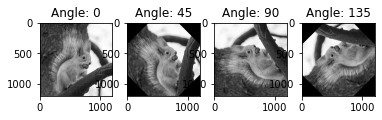

Angle 0:
  Original HOG diff L1: 0.0000
  Invariant HOG diff L1: 0.0000
  Original HOG diff L2: 0.0000
  Invariant HOG diff L2: 0.0000
Angle 45:
  Original HOG diff L1: 105158.1407
  Invariant HOG diff L1: 44455.3398
  Original HOG diff L2: 245.2391
  Invariant HOG diff L2: 112.8617
Angle 90:
  Original HOG diff L1: 114295.9245
  Invariant HOG diff L1: 44838.0781
  Original HOG diff L2: 255.9909
  Invariant HOG diff L2: 106.6434
Angle 135:
  Original HOG diff L1: 109449.4438
  Invariant HOG diff L1: 45626.4922
  Original HOG diff L2: 251.3348
  Invariant HOG diff L2: 114.1771


In [85]:
compare_hog_descriptors("squirrel.jpg")

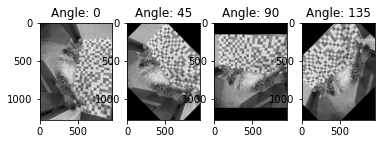

Angle 0:
  Original HOG diff L1: 0.0000
  Invariant HOG diff L1: 0.0000
  Original HOG diff L2: 0.0000
  Invariant HOG diff L2: 0.0000
Angle 45:
  Original HOG diff L1: 92343.7954
  Invariant HOG diff L1: 39222.4531
  Original HOG diff L2: 228.4974
  Invariant HOG diff L2: 106.7077
Angle 90:
  Original HOG diff L1: 90870.4579
  Invariant HOG diff L1: 40154.1875
  Original HOG diff L2: 225.7078
  Invariant HOG diff L2: 109.6557
Angle 135:
  Original HOG diff L1: 95524.3152
  Invariant HOG diff L1: 40813.7852
  Original HOG diff L2: 232.4912
  Invariant HOG diff L2: 108.0806


In [86]:
compare_hog_descriptors("thor.jpg")

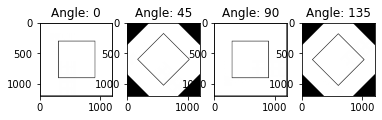

Angle 0:
  Original HOG diff L1: 0.0000
  Invariant HOG diff L1: 0.0000
  Original HOG diff L2: 0.0000
  Invariant HOG diff L2: 0.0000
Angle 45:
  Original HOG diff L1: 14193.8623
  Invariant HOG diff L1: 24430.2188
  Original HOG diff L2: 82.7465
  Invariant HOG diff L2: 111.0850
Angle 90:
  Original HOG diff L1: 9552.6122
  Invariant HOG diff L1: 24867.5859
  Original HOG diff L2: 55.8974
  Invariant HOG diff L2: 111.5400
Angle 135:
  Original HOG diff L1: 14627.4610
  Invariant HOG diff L1: 26711.2812
  Original HOG diff L2: 83.5700
  Invariant HOG diff L2: 117.7382


In [87]:
compare_hog_descriptors("square.jpg")

In [88]:
desc_original = []
desc_invariant = []

desc_orig = hog(gray_img)
desc_invar = hog_rot_invariant(gray_img)

desc_original.append(desc_orig)
desc_invariant.append(desc_invar)

print(desc_orig)
print(len(desc_orig))

print(desc_invar)
print(len(desc_invar))

[1.         0.07692308 0.15384615 ... 0.02941176 0.02941176 0.        ]
360000
[0.65813625 0.04832915 0.177695   ... 0.         0.         0.14624079]
360000


In [89]:
print(desc_original)
print(type(desc_original))
print(len(desc_original))

print(desc_original[0])
print(len(desc_original[0]))

[array([1.        , 0.07692308, 0.15384615, ..., 0.02941176, 0.02941176,
       0.        ])]
<class 'list'>
1
[1.         0.07692308 0.15384615 ... 0.02941176 0.02941176 0.        ]
360000


In [90]:
diff_original = np.linalg.norm(descriptors_original[0] - descriptors_original[i])
diff_invariant = np.linalg.norm(descriptors_invariant[0] - descriptors_invariant[i])

NameError: name 'descriptors_original' is not defined